### Import packages

In [1]:
import os
import chess
import chess.engine
import pandas as pd
import numpy as np
from plotting_functions import plot_heat_map, plot_samples

# run it in parallel
#from joblib import Parallel, delayed

from multiprocess import Process, Pool

## Define Functions

#### Functions to convert stockfish's scoring into sensible metrics of estiamted win/loss probability

In [2]:
# for cp to wp
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cp_to_wp(score_val_cp_white):
    """
    Converts centipawn score val (signed with white pos/black neg) to win prob for white
    
    Args:
        score_val_cp_white: centipawn value (signed with white positive black negative) for position
    Returns:
        win probability: measure between 0 and 1 giving probability of white win
        Note: taken for logistic regression model applied to predict win given centipawn games
    """
    this_const = -0.045821224987387915;
    this_board_score_val = 0.002226678310106879
    #return sigmoid(log_reg_cp.params['const'] + log_reg_cp.params['board_score_val']*score_val_cp_white)
    return sigmoid(this_const + this_board_score_val*score_val_cp_white)

def mate_to_wp(score_val_mate):
    """
    Converts plys from mate to win prob (for the player who is within reach of mate)
    """
    # return sigmoid(log_reg_mate.params['const'] + log_reg_mate.params['score_val_pos']*np.abs(score_val_mate))
    return sigmoid(3.6986223572286208 + -0.05930670977061789*np.abs(score_val_mate))


# add support for if mate == 0!!!!!!!
def process_score(this_score, white_active):
    """
    Input:
    this score:  what is returned from stockfish
    white active: is whether it is white's move
    
    Output:
    score_dict: contains
    """
    
    white_score = this_score.white()
    is_mate = white_score.is_mate()
    
    if is_mate:
        score_type = 'mate'
        score_val = white_score.mate() # this is framed as white'
        if score_val > 0:
            wp = mate_to_wp(score_val) # this is framed as whichever side is close to mate
        elif score_val < 0:
            wp = 1 - mate_to_wp(score_val)
        elif score_val == 0:
            wp = 1 if white_active else 0
            # 1 or -1 depending on whose move this is.... so process score needs to take in who is active
    else: # centipawn...
        score_type = 'cp'
        score_val = white_score.score()
        wp = cp_to_wp(score_val)
    
    wp_active = wp if white_active else 1 - wp
        
    #score_dict = {'type': score_type, 'val': score_val, 'wp': wp}
    return wp_active


#### Functions to sample a construal board from prior

In [14]:
def get_neighbouring_squares(square):
    neighbours = []
    if square>=8:
        neighbours += [square-8]
    if square<56:
        neighbours += [square+8]
    if square%8>0:
        neighbours += [square-1]
    if square%8<7:
        neighbours += [square+1]
    return neighbours

def perturb_board(board,pdrop=0.95,pmove=0.1, move_selected = ''):

    while True:
        new_board = board.copy()
        piece_map = new_board.piece_map()
        
        if move_selected == '':
            moved_from_square = ''
        else:
            moved_from_square = chess.Move.from_uci(move_selected).from_square

        new_piece_map = piece_map.copy()
        #step 1: drop pieces - don't drop the kings or the piece that was moved
        for square in piece_map:
            if (np.random.binomial(1,pdrop)>0) & (piece_map[square] != chess.Piece.from_symbol('K')) & (piece_map[square] != chess.Piece.from_symbol('k')) & (square != moved_from_square):
                del new_piece_map[square]

        #step 2: move pieces
        occupied_squares = list(new_piece_map.keys())
        np.random.shuffle(occupied_squares)

        for square in occupied_squares:
            # don't move piece that was moved
            if np.random.binomial(1,pmove)>0 & (square != moved_from_square):
                new_squares = get_neighbouring_squares(square)
                new_square = np.random.choice(new_squares)
                if not new_square in piece_map:
                    new_piece_map[new_square] = new_piece_map.pop(square)

        new_board.set_piece_map(new_piece_map)
        if new_board.is_valid():
            return new_board

#### Function to evaluate construal board (likelihood)

In [43]:
def eval_construal_lik(construal_board, move_selected, this_white_active, engine, eval_depth, B=500):

    #eval_depth=13
    if construal_board.is_checkmate() | construal_board.is_stalemate():
        
        move_lik = 0
        
    else:
    
        # get list of possible moves (max = 30) from this construal (consideration_set)
        engine.configure({"Clear Hash": None})
        info = engine.analyse(construal_board, chess.engine.Limit(depth=eval_depth), multipv=10)

        consideration_set = []
        # Vprint(info)
        if isinstance(info, list):
            for i in range(len(info)):
                this_move = info[i]['pv'][0]
                consideration_set.append(this_move.uci())
        else:
            this_move = info['pv'][0]
            consideration_set.append(this_move.uci())

        # evaluate each of these moves by pushing them onto the board    
        unique_consideration_set = np.unique(consideration_set)
        unique_consideration_set = np.insert(unique_consideration_set,0,move_selected)

        action_scores_orig_format = []
        action_scores_processed = []

        for this_move in unique_consideration_set:
            try:
                new_board = construal_board.copy()
                new_board.push_uci(this_move)
                engine.configure({"Clear Hash": None})
                info_new = engine.analyse(new_board, chess.engine.Limit(depth=eval_depth))        
                processed_score = process_score(info_new['score'], this_white_active)

            except:
                break # this means the first move failed to get onto the board

            action_scores_processed.append(processed_score)
            
        action_scores_processed = np.array(action_scores_processed)
    
        # compute move likelihood    
        if len(action_scores_processed) == 0:
            move_lik = 0
        else:
            # B = 500
            move_lik = np.exp(B*action_scores_processed[0])/np.sum(np.exp(B*action_scores_processed))
        
    return move_lik


### Function to sample board positions along with likelihoods

In [49]:
def draw_single_sample(current_board, move_selected, white_active, engine, eval_depth=10, n_samples=300, pdrop=.2, pmove=.2, B = 500):
    
    construal_board = perturb_board(current_board,pdrop=pdrop,pmove=pmove, move_selected = move_selected)

    # check if the board is checkmate
    if construal_board.is_checkmate() | construal_board.is_stalemate():
        construal_lik = 0
    else:    
        construal_lik = eval_construal_lik(construal_board, move_selected, white_active, engine, eval_depth, B = B)
    #return construal_board.fen() 
    return construal_board.fen(), construal_lik

def draw_construal_samples(current_board, move_selected, white_active, engine, eval_depth=10, n_samples=300, pdrop=.2, pmove=.2, B = 500):
    construal_list = []
    lik_list = []
    for s_idx in range(n_samples):
        print(s_idx, end= ' ')
        
        
        construal_board_fen, construal_lik = draw_single_sample(current_board, move_selected, white_active, engine, eval_depth=eval_depth, n_samples=n_samples, pdrop=pdrop, pmove=pmove, B = B)

        construal_list.append(construal_board_fen)
        lik_list.append(construal_lik)
        
    sample_df = pd.DataFrame({'fen': construal_list, 'lik': lik_list})

    return sample_df


#### Set up folders to stockfish

Download stockfish from: https://stockfishchess.org/download/

In [17]:
stockfish_path = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Chess_Engines/stockfish/15/bin/stockfish"

#### Initialize the engine

Use the python-chess package to communicate with the engine.

https://python-chess.readthedocs.io/en/latest/engine.html

In [82]:
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

## Example Positions

### Position 1

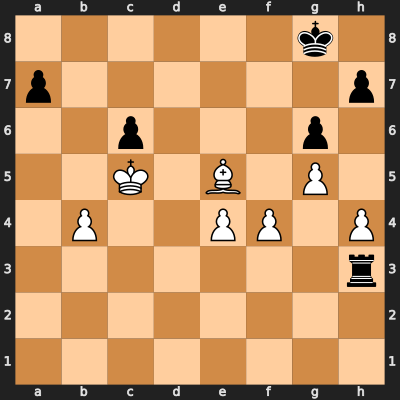

In [83]:
this_fen = '6k1/p6p/2p3p1/2K1B1P1/1P2PP1P/7r/8/8 b - - 2 43'
current_board = chess.Board(this_fen)
white_active = False
chess.svg.board(current_board, size = 400)

#### Draw example construal

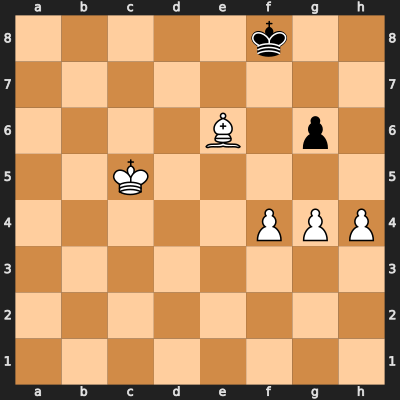

In [84]:
ex_construal = perturb_board(current_board,pdrop=0.5,pmove=0.2)
chess.svg.board(ex_construal, size = 400)

#### Find good move in construal

In [85]:
info = engine.analyse(ex_construal, chess.engine.Limit(depth=15))
display(info['pv'][0])


Move.from_uci('f8g7')

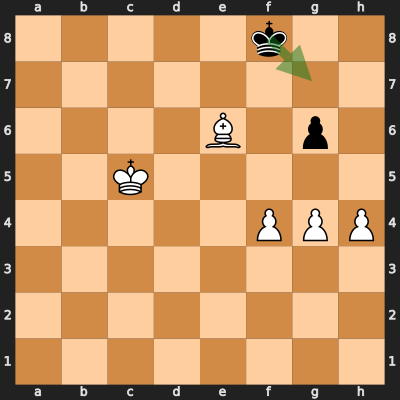

In [87]:
chess.svg.board(ex_construal, size = 400, arrows=[(chess.F8, chess.G7)])

#### Examine a blunder

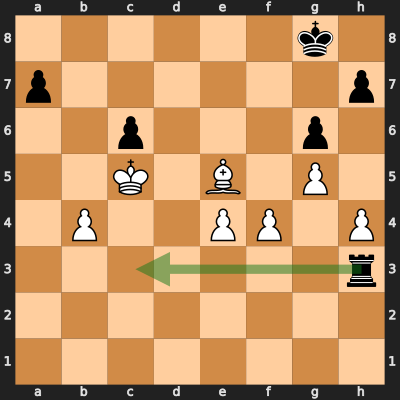

In [88]:
# examine a potential blunder
current_board = chess.Board(this_fen)
move_selected = 'h3c3'
chess.svg.board(current_board, arrows=[(chess.H3, chess.C3)], size = 400)
# get the construal un

Draw samples

In [89]:
sample_df = draw_construal_samples(current_board, move_selected, white_active, engine, eval_depth=10, n_samples=500, pdrop=.3, pmove=.5, B = 500)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

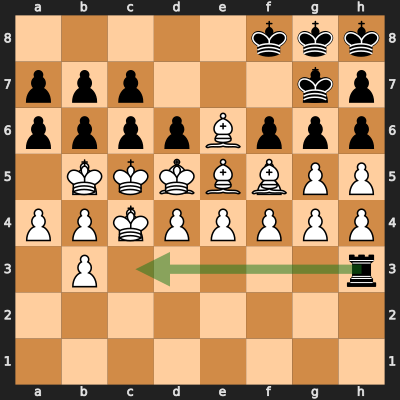

In [90]:
plot_samples(this_fen,move_selected,sample_df)

Examine a better move

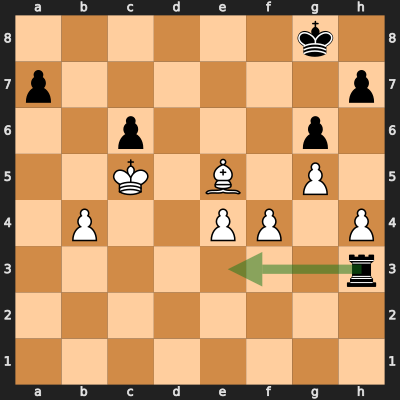

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [91]:
move_selected = 'h3e3'
display(chess.svg.board(current_board, arrows=[(chess.H3, chess.E3)], size = 400))
sample_df = draw_construal_samples(current_board, move_selected, white_active, engine, eval_depth=10, n_samples=500, pdrop=.3, pmove=.5, B = 500)

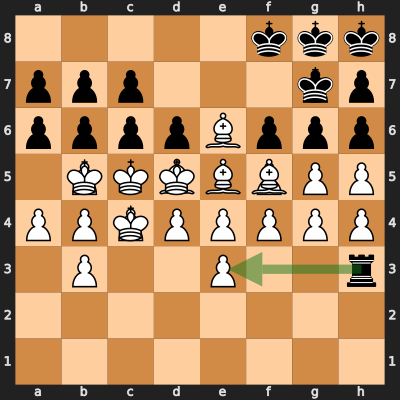

In [55]:
plot_samples(this_fen,move_selected,sample_df)

### Example position 2

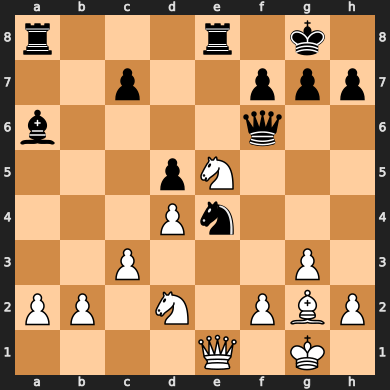

In [67]:
this_fen = 'r3r1k1/2p2ppp/b4q2/3pN3/3Pn3/2P3P1/PP1N1PBP/4Q1K1 w'
current_board = chess.Board(this_fen)
current_board

Examine Good Move

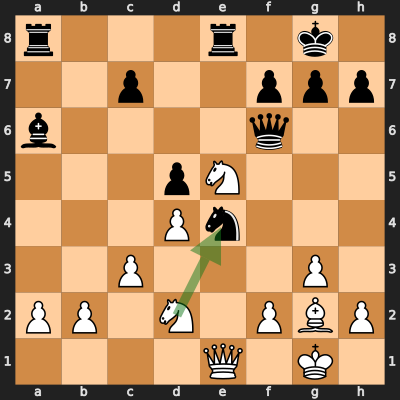

In [69]:
move_selected = 'd2e4'
display(chess.svg.board(current_board, arrows=[(chess.D2, chess.E4)], size = 400))

In [72]:
sample_df = draw_construal_samples(current_board, move_selected, True, engine, eval_depth=10, n_samples=500, pdrop=.3, pmove=.5)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

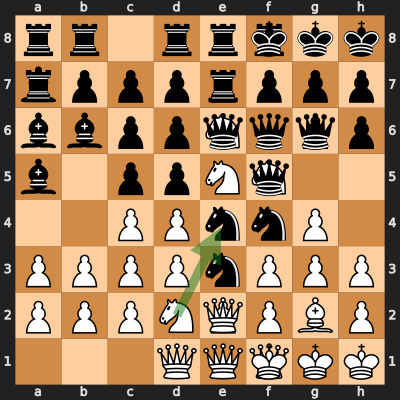

In [75]:
plot_samples(this_fen,move_selected,sample_df)

#### Example position 3

Examine missing the fork

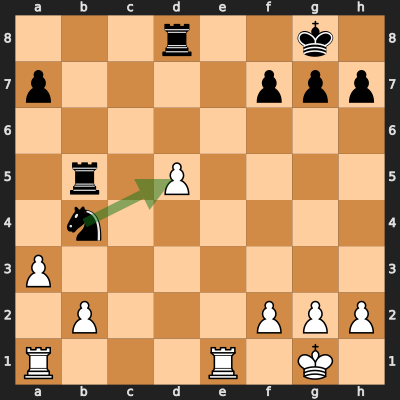

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [37]:
this_fen = '3r2k1/p4ppp/8/1r1P4/1n6/P7/1P3PPP/R3R1K1 b'
current_board = chess.Board(this_fen)
move_selected = 'b4d5'
display(chess.svg.board(current_board, arrows=[(chess.B4, chess.D5)], size = 400))
sample_df = draw_construal_samples(current_board, move_selected, False, engine, eval_depth=10, n_samples=500, pdrop=.3, pmove=.5)

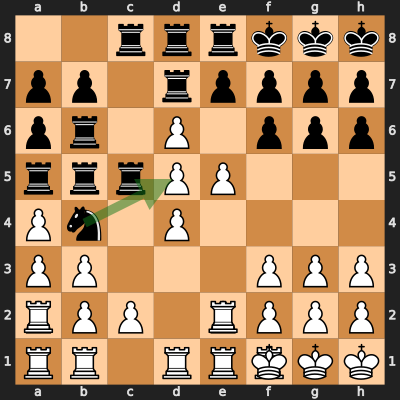

In [38]:
plot_samples(this_fen,move_selected,sample_df)

Examing choosing the fork

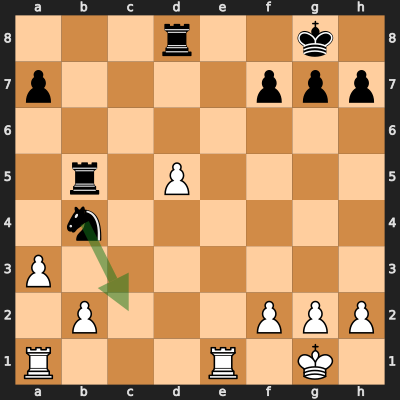

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [39]:
move_selected = 'b4c2'
display(chess.svg.board(current_board, arrows=[(chess.B4, chess.C2)], size = 400))
sample_df = draw_construal_samples(current_board, move_selected, False, engine, eval_depth=10, n_samples=500, pdrop=.3, pmove=.5)

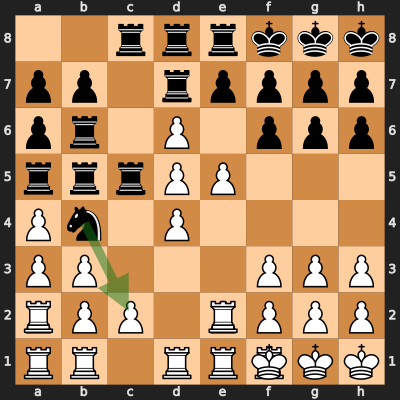

In [41]:
plot_samples(this_fen,move_selected,sample_df)